In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import sys

# Data load and transformation

Due to MRI's format, pictures are transformed to grayscale images. 128x128 size is chosen to balance trade-off between picture quality and accuracy. Data augmentation is used to improve model performance. Normalization is used to keep tensor values in [-1,1] range.

In [ ]:
'''
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),            # Resize images to 128x128
    transforms.RandomRotation(15),           # Data augmentation**
    transforms.RandomHorizontalFlip(0.5),   # Data augmentation**
    transforms.RandomVerticalFlip(0.5),     # Data augmentation**
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Data augmentation**
    transforms.ToTensor(),          # Convert to Tensor [0,1]
    transforms.Normalize([0.5], [0.5])          # Normalize (adjust values to [-1,1])

])
'''
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# SEPARATE VALIDATION TRANSFORM - No augmentation for validation
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

torch.manual_seed(42)

In [ ]:
# IMPROVED DATA LOADING WITH AUGMENTATION
train_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Training', transform=transform_train)
val_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Testing', transform=transform_val)

# INCREASED BATCH SIZE FOR BETTER TRAINING STABILITY
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Changed to shuffle=True and batch_size=64
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)     # Increased batch_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Network Structure
We designed a 4-layer convolutional neural network tailored for brain tumor classification:

- 4 convolutional blocks with increasing filters (32 → 256) to capture deep features

- Each block uses Batch Normalization, ReLU, and MaxPooling

- Added Adaptive Average Pooling for better spatial compression

- Used Dropout (0.5) and two fully connected layers to reduce overfitting

- Final layer outputs 4 tumor classes

In [ ]:
# ENHANCED CNN ARCHITECTURE
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)      # Increased filters from 16 to 32
        self.bn1 = nn.BatchNorm2d(32)                                # Added Batch Normalization

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)     # Increased filters from 32 to 64
        self.bn2 = nn.BatchNorm2d(64)                                # Added Batch Normalization

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)    # Increased filters from 64 to 128
        self.bn3 = nn.BatchNorm2d(128)                               # Added Batch Normalization

        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)   # Added fourth conv layer
        self.bn4 = nn.BatchNorm2d(256)                               # Added Batch Normalization

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))            # Added adaptive pooling
        self.dropout = nn.Dropout(0.5)                               # Increased dropout from 0.25 to 0.5

        # Enhanced Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)                       # Adjusted for new architecture
        self.fc2 = nn.Linear(512, 128)                               # Added intermediate FC layer
        self.fc3 = nn.Linear(128, num_classes)                       # Final classification layer

    def forward(self, x):
        # Enhanced forward pass with batch normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.adaptive_pool(x)                                    # Adaptive pooling
        x = x.view(x.size(0), -1)                                    # Improved flattening

        # Enhanced fully connected layers with more dropout
        x = self.dropout(F.relu(self.fc1(x)))                        # Increased dropout
        x = self.dropout(F.relu(self.fc2(x)))                        # New FC layer with dropout
        x = self.fc3(x)                                              # Final layer
        return x

model = BrainTumorCNN(num_classes=4).to(device)

In [ ]:
# IMPROVED LOSS FUNCTION AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)  # Added learning rate scheduler


In [ ]:
# ENHANCED TRAINING LOOP WITH VALIDATION
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Store metrics
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_accuracies

Starting training with enhanced architecture...
Epoch 1/20 | Train Loss: 0.9692 | Train Acc: 59.03% | Val Acc: 63.77%
Epoch 2/20 | Train Loss: 0.7279 | Train Acc: 71.11% | Val Acc: 68.95%
Epoch 3/20 | Train Loss: 0.6630 | Train Acc: 73.55% | Val Acc: 60.64%
Epoch 4/20 | Train Loss: 0.6259 | Train Acc: 74.49% | Val Acc: 54.23%
Epoch 5/20 | Train Loss: 0.6271 | Train Acc: 76.09% | Val Acc: 74.45%
Epoch 6/20 | Train Loss: 0.5657 | Train Acc: 76.82% | Val Acc: 74.22%
Epoch 7/20 | Train Loss: 0.5196 | Train Acc: 79.17% | Val Acc: 80.85%
Epoch 8/20 | Train Loss: 0.4871 | Train Acc: 81.97% | Val Acc: 71.62%
Epoch 9/20 | Train Loss: 0.4560 | Train Acc: 82.97% | Val Acc: 79.48%
Epoch 10/20 | Train Loss: 0.4343 | Train Acc: 84.44% | Val Acc: 82.68%
Epoch 11/20 | Train Loss: 0.4106 | Train Acc: 84.23% | Val Acc: 80.63%
Epoch 12/20 | Train Loss: 0.3972 | Train Acc: 85.42% | Val Acc: 76.81%
Epoch 13/20 | Train Loss: 0.3723 | Train Acc: 86.10% | Val Acc: 80.40%
Epoch 14/20 | Train Loss: 0.3390 | Tra

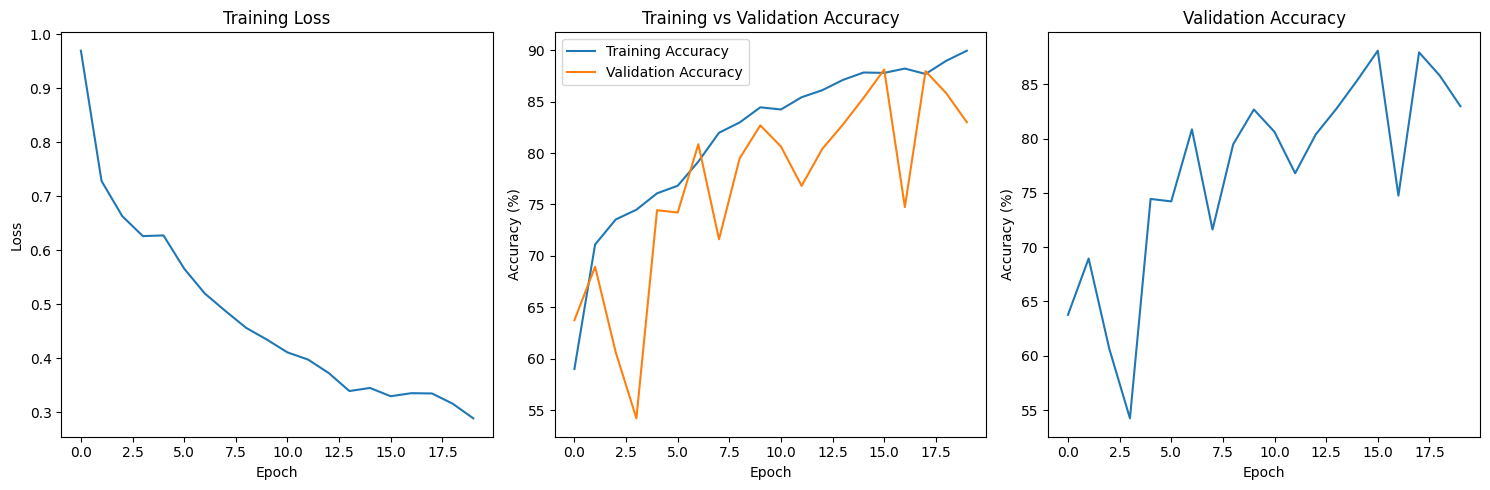

In [ ]:
# TRAIN THE ENHANCED MODEL
print("Starting training with enhanced architecture...")
train_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# PLOT TRAINING RESULTS
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [ ]:
# SAVE THE MODEL
torch.save(model.state_dict(), '/content/drive/MyDrive/ML2 Project/brain_tumor_cnn_enhanced.pth')
print("Model saved successfully!")


Model saved successfully!


In [11]:
# FINAL EVALUATION
model.eval()
correct = 0
total = 0
class_correct = [0] * 4
class_total = [0] * 4

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Per-class accuracy
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
print("\nPer-class accuracies:")
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in range(4):
    if class_total[i] > 0:
        print(f"{class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")



Final Test Accuracy: 22.54%

Per-class accuracies:
glioma_tumor: 0.00%
meningioma_tumor: 0.00%
no_tumor: 0.00%
pituitary_tumor: 100.00%


# BETTER MODEL (using ResNet)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training with ResNet18...
Epoch 1/17 | Train Loss: 0.3643 | Train Acc: 86.54% | Val Acc: 83.62%
Epoch 2/17 | Train Loss: 0.2186 | Train Acc: 92.02% | Val Acc: 75.28%
Epoch 3/17 | Train Loss: 0.1565 | Train Acc: 94.92% | Val Acc: 90.76%
Epoch 4/17 | Train Loss: 0.1450 | Train Acc: 94.63% | Val Acc: 95.79%
Epoch 5/17 | Train Loss: 0.1337 | Train Acc: 95.34% | Val Acc: 89.93%
Epoch 6/17 | Train Loss: 0.1068 | Train Acc: 96.46% | Val Acc: 71.98%
Epoch 7/17 | Train Loss: 0.1282 | Train Acc: 95.34% | Val Acc: 88.88%
Epoch 8/17 | Train Loss: 0.1015 | Train Acc: 96.74% | Val Acc: 96.77%
Epoch 9/17 | Train Loss: 0.1287 | Train Acc: 95.54% | Val Acc: 93.99%
Epoch 10/17 | Train Loss: 0.0897 | Train Acc: 96.97% | Val Acc: 95.12%
Epoch 11/17 | Train Loss: 0.0883 | Train Acc: 96.92% | Val Acc: 96.54%
Epoch 12/17 | Train Loss: 0.0786 | Train Acc: 97.29% | Val Acc: 98.42%
Epoch 13/17 | Train Loss: 0.0770 | Train Acc: 97.27% | Val Acc: 91.21%
Epoch 14/17 | Train Loss: 0.0869 | Train Acc: 97.25

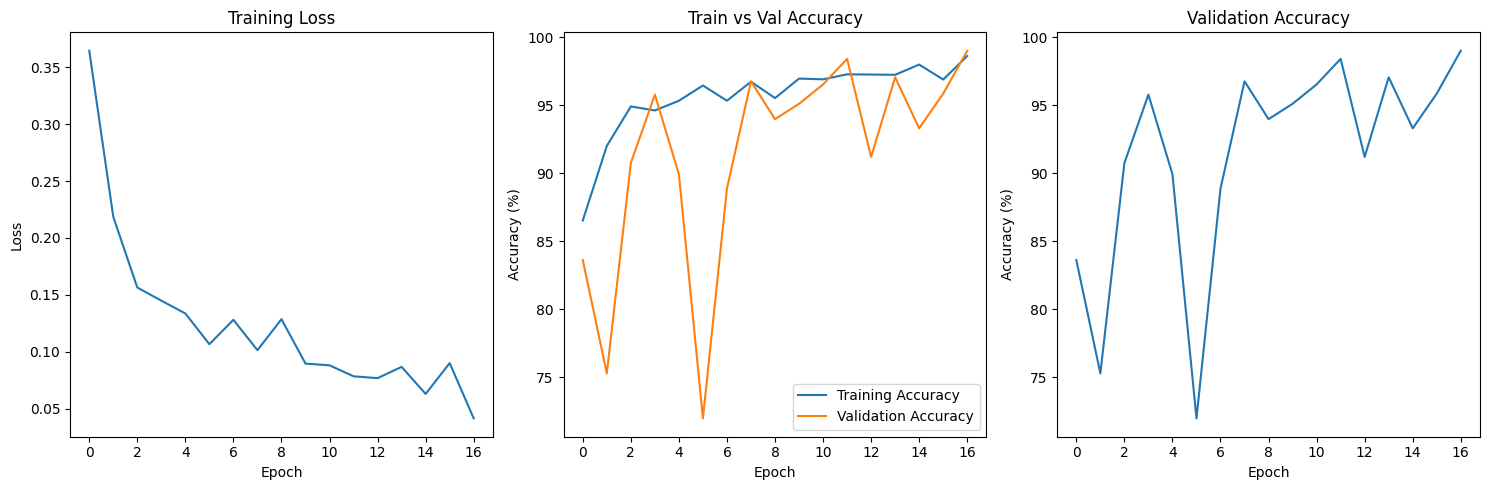

Model saved successfully!

Final Test Accuracy: 99.02%

Per-class accuracies:
glioma_tumor: 97.74%
meningioma_tumor: 98.10%
no_tumor: 100.00%
pituitary_tumor: 100.00%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)

# ------------------- Transforms -------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Grayscale(num_output_channels=1),  # if the images are RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # if the images are RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset and Loader:
train_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Training', transform=transform_train)
val_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Testing', transform=transform_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Modified ResNet:
class BrainTumorResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = BrainTumorResNet(num_classes=4).to(device)

# Loss, Optimizer, Scheduler:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training Function:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=1):
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        scheduler.step(avg_val_loss)

        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_accuracies

# Train:
print("Starting training with ResNet18...")
train_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=17)

# Plot Results:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Train vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accs)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# ------------------- Save Model -------------------
torch.save(model.state_dict(), '/content/drive/MyDrive/ML2 Project/resnet18_brain_tumor.pth')
print("Model saved successfully!")

# ------------------- Final Evaluation -------------------
model.eval()
correct = 0
total = 0
class_correct = [0] * 4
class_total = [0] * 4
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
print("\nPer-class accuracies:")
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in range(4):
    if class_total[i] > 0:
        print(f"{class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")


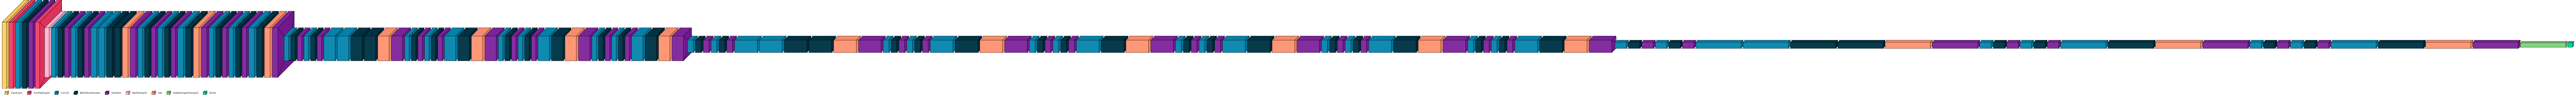

In [ ]:
import visualkeras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50

model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=3)

visualkeras.layered_view(model, legend=True, max_xy=300)

# CONFUSION MATRIX


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

torch.manual_seed(42)
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Transforms -------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Grayscale(num_output_channels=1),  # if your images are RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # if your images are RGB
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])



# ------------------- Dataset and Loader -------------------
train_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Training', transform=transform_train)
val_data = datasets.ImageFolder('/content/drive/MyDrive/ML2 Project/Testing', transform=transform_val)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

Using device: cpu


   True Label  Predicted Label
0           0                0
1           0                0
2           0                0
3           0                0
4           0                0


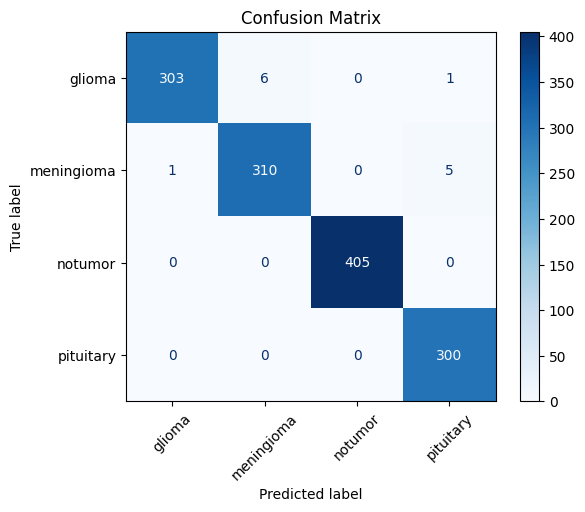

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import torch.nn as nn
from torchvision import models

# Define the custom model class (same as used during training)
class BrainTumorResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize model with same architecture
model = BrainTumorResNet(num_classes=4)

# Load saved state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/ML2 Project/resnet18_brain_tumor.pth', map_location='cpu'))

# Send to device and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


# Inference
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Convert to tabular format
df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': pred_labels
})

print(df.head())

# Map class indices to names
class_names = val_data.classes
df['True Label Name'] = df['True Label'].apply(lambda x: class_names[x])
df['Predicted Label Name'] = df['Predicted Label'].apply(lambda x: class_names[x])

# Confusion matrix
cm = confusion_matrix(df['True Label'], df['Predicted Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()